## Overall variance

Words with the highest overall variance in the smoothed time series data. Captures words that dramatically increase, decrease, spike, fluctuate:

In [29]:
import math
import numpy as np

from hol.topn_series import TopnSeries

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

topns = TopnSeries(range(1780, 1920), depth=500, level1=5)

def small_multiples(result, n=50, cols=5):

    topn = list(result.items())[:n]
    
    # Get X-axis range.
    y1 = list(topns.years)[0]
    y2 = list(topns.years)[-1]
    
    # Calculate the row count and figure size.
    rows = math.ceil(n / 5)
    figsize = (cols*2, rows*2)
    
    # Make the figure + axes.
    fig, axarr = plt.subplots(rows, cols, figsize=figsize, sharey='row')
    fig.tight_layout(pad=0, h_pad=2, w_pad=0.1)
    
    for i, (token, score) in enumerate(topn):
        
        ax = axarr[math.floor(i/cols)][i%cols]
        
        # Query the smoothed rank series.
        series = topns.rank_series_smooth(token)
            
        ax.set_title(token)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
        ax.tick_params(labelsize=8)
        ax.set_xlim(y1, y2)
        ax.set_ylim(0, topns.depth)

        ax.plot(
            *zip(*series.items()),
            linestyle='none',
            marker=".",
            markersize=3,
        )

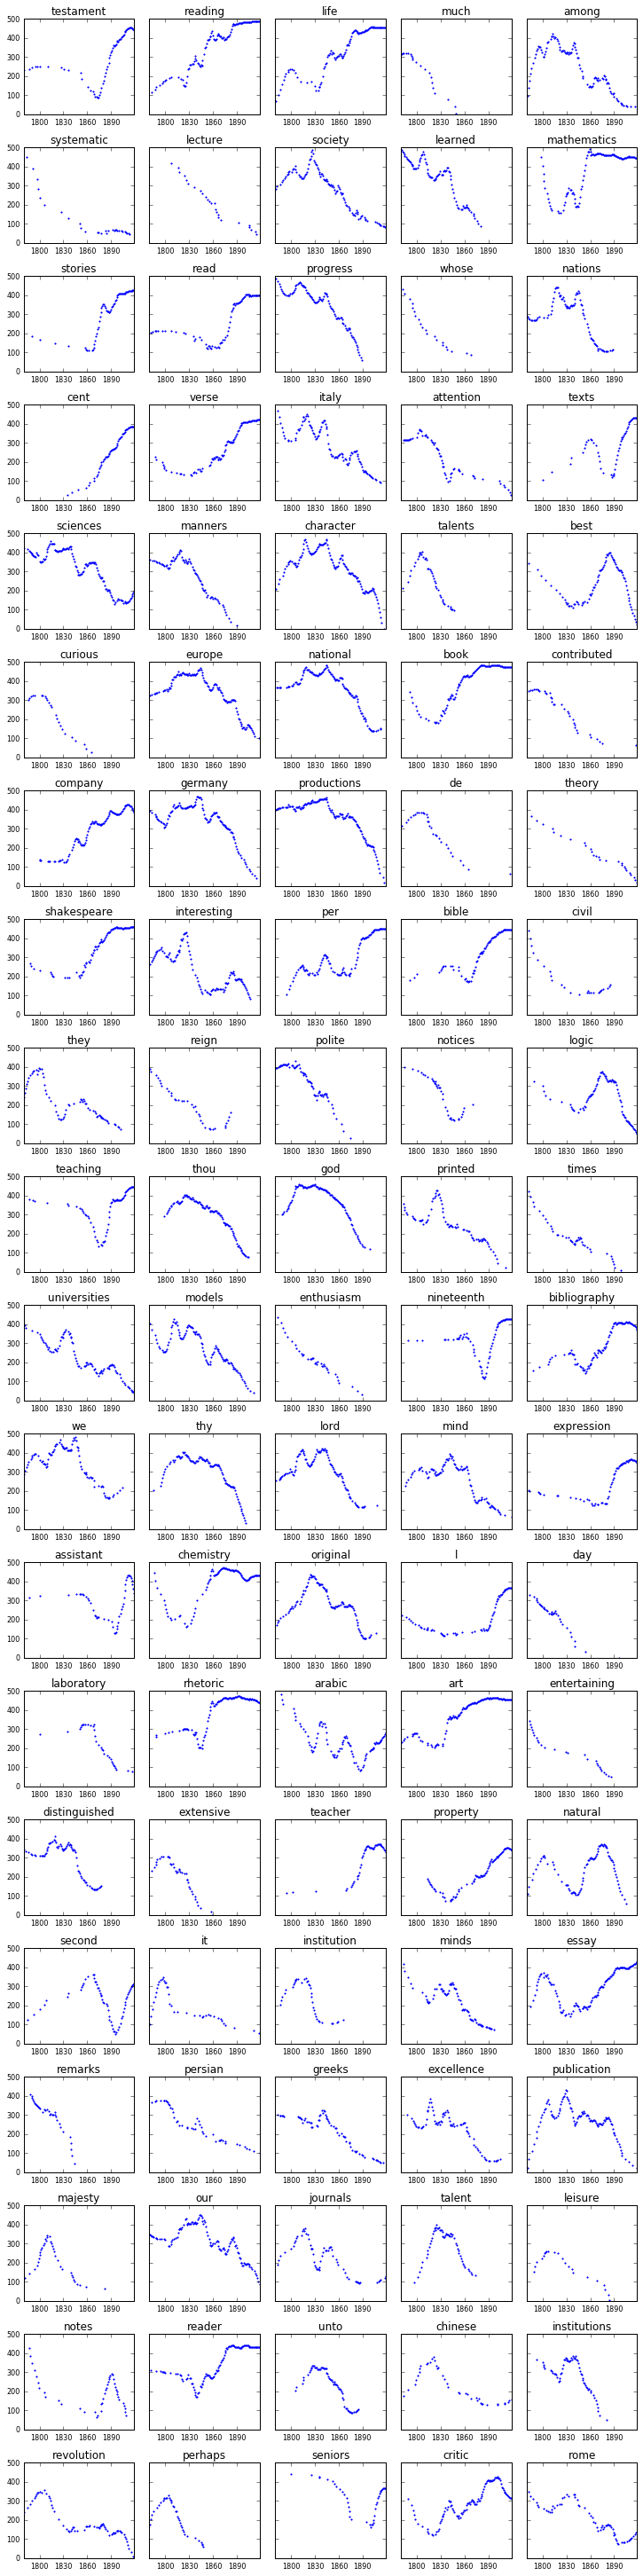

In [16]:
def print_series_query(_lambda, *args, **kwargs):
    result = topns.sort_smoothed_rank_series(_lambda)
    small_multiples(result, *args, **kwargs)

def score(s):
    return np.var(list(s.values()))

print_series_query(score, n=100)

## Trending up

Words that show the largest overall increase in rank over time:

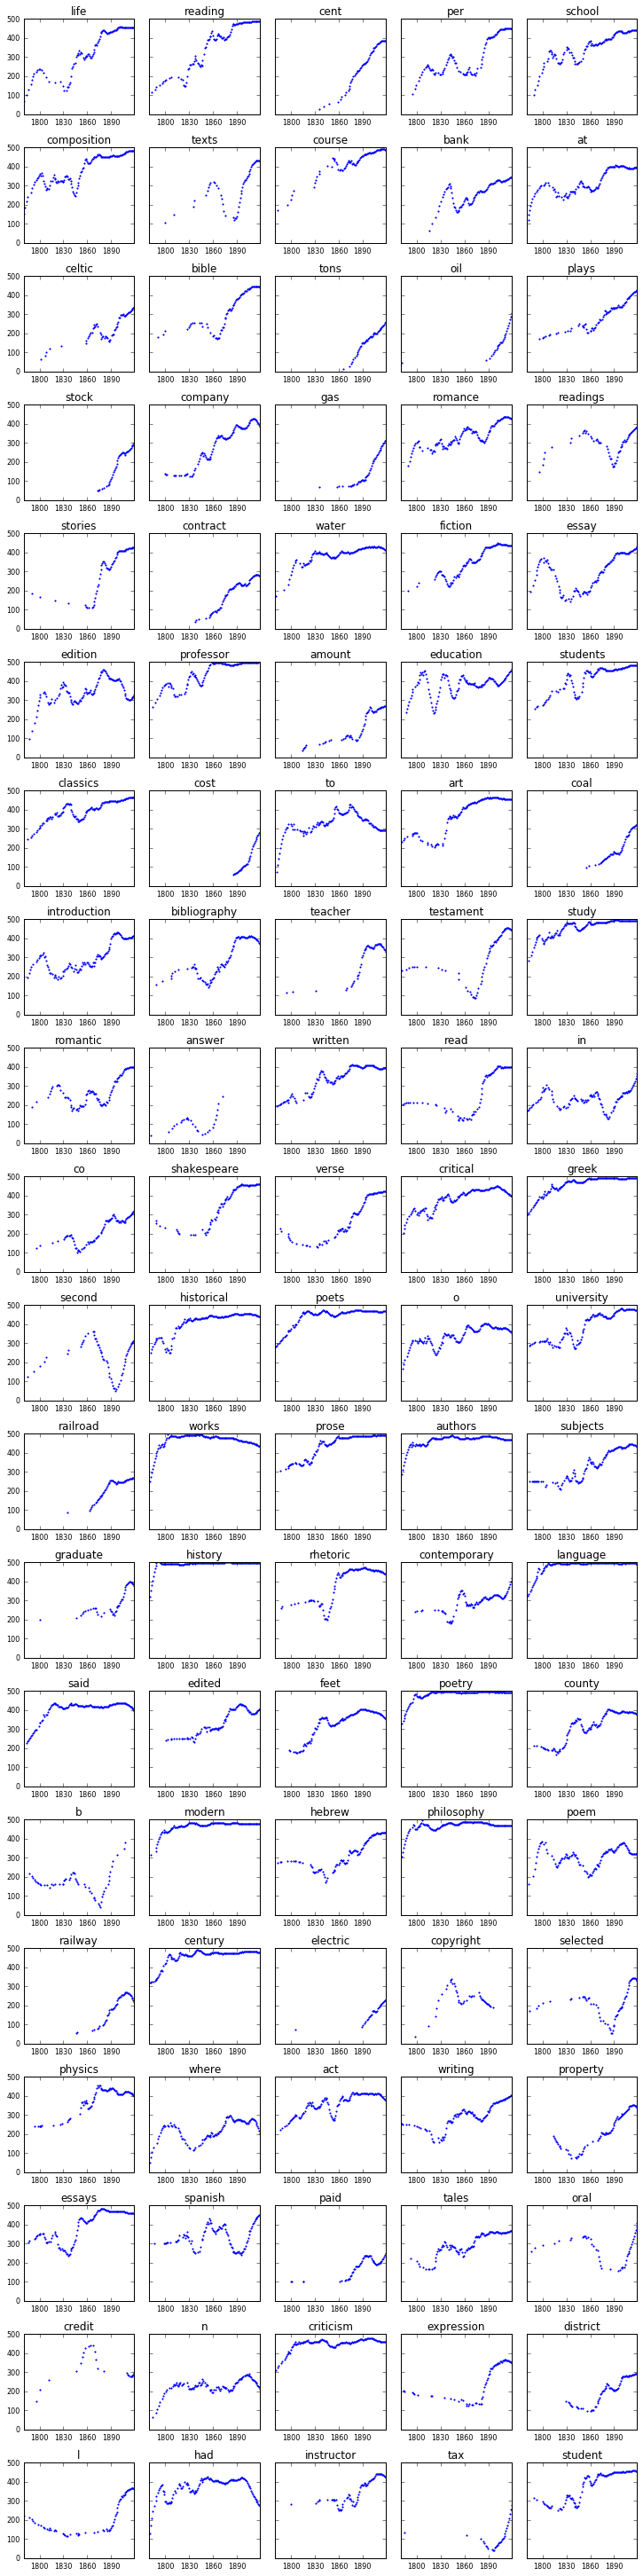

In [17]:
def score(s):
    y = list(s.values())
    return y[-1] - y[0]

print_series_query(score, n=100)

## Trending down

Words that show the largest overall decrease in rank over time:

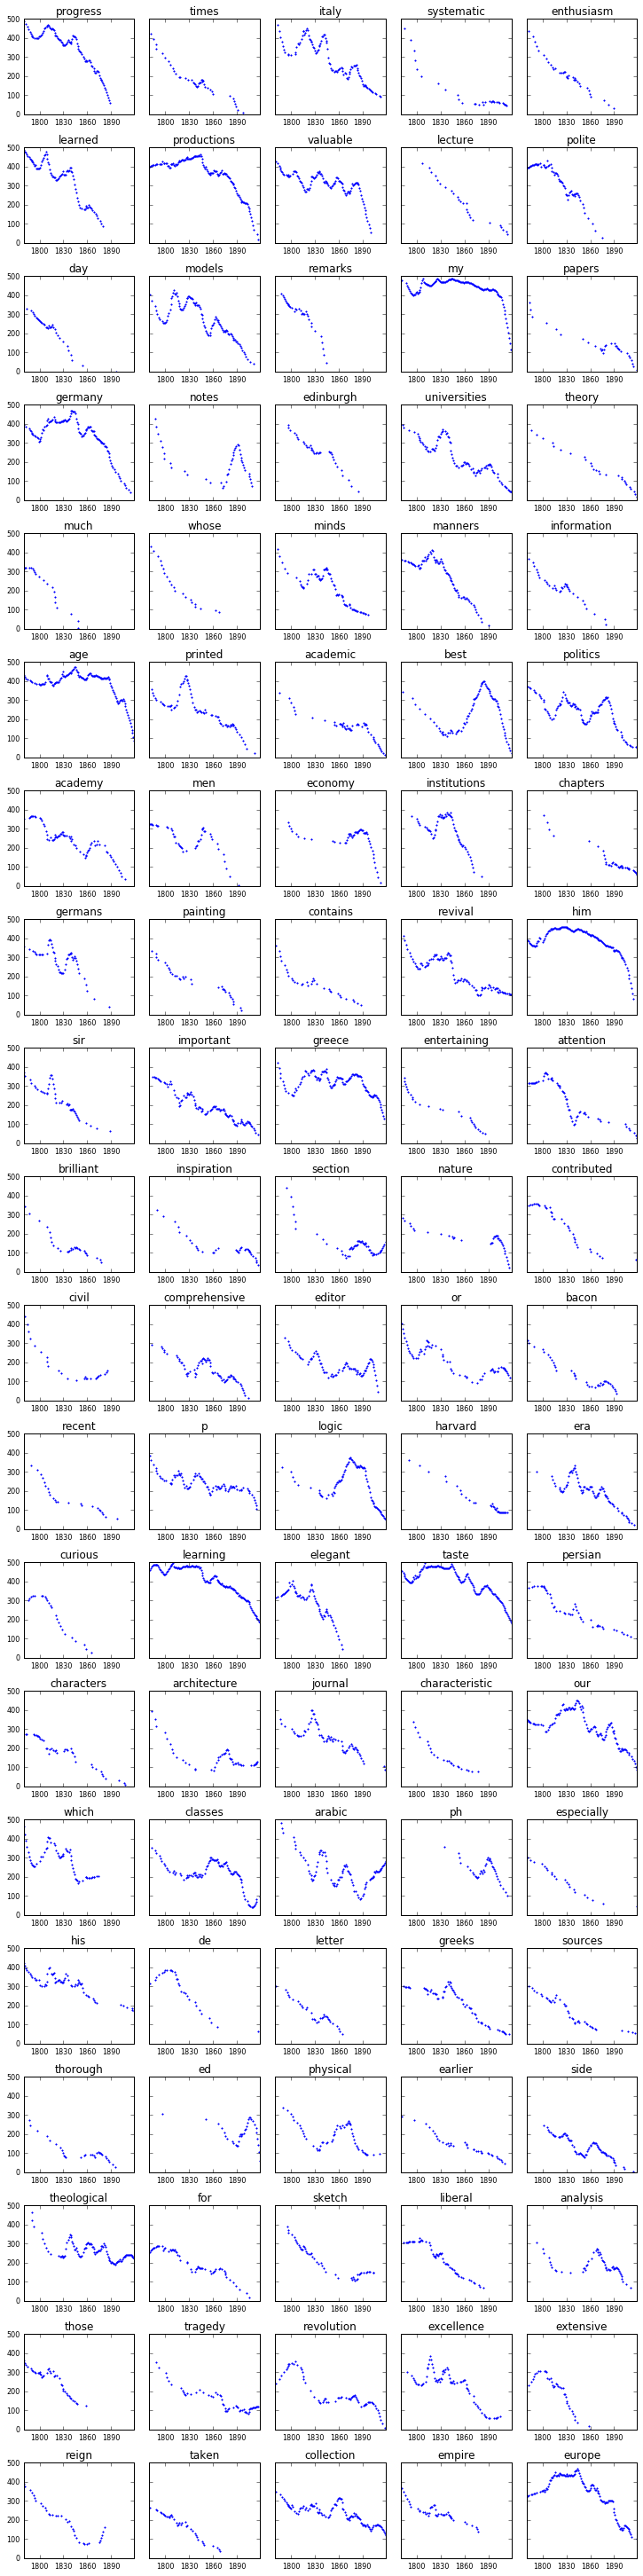

In [18]:
def score(s):
    y = list(s.values())
    return y[0] - y[-1]

print_series_query(score, n=100)

## Constant

Words that stay in the same place in the rankings over time:

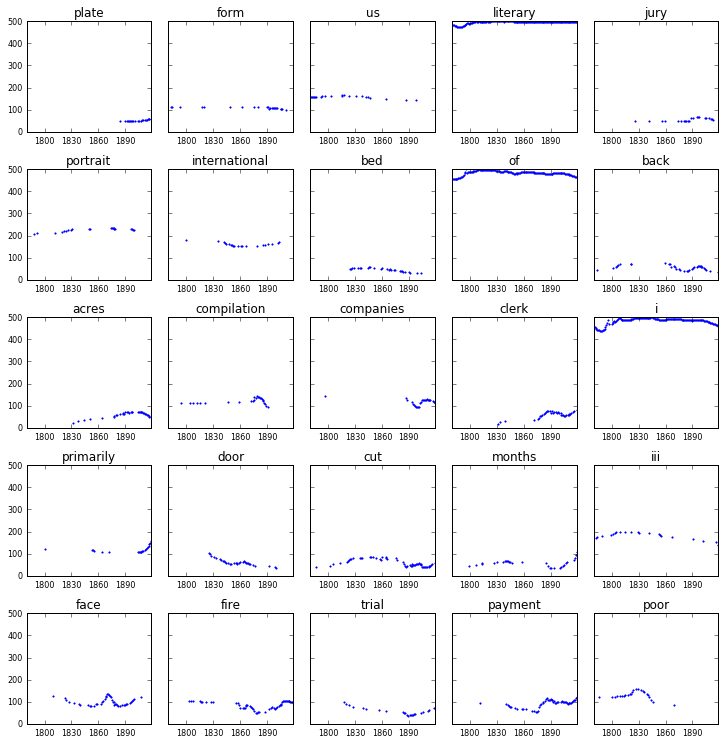

In [19]:
def score(s):
    return -np.var(list(s.values()))

print_series_query(score, n=25)

But, this doens't work as well because we're picking up on words that have low variance but that only show up for a very short amount of time, like "plate." What we want, really, is a way to capture the _trend_ of a word over a period of time, instead of just doing summary stats on the raw set of rank positions for a word - something that can pick out the difference between "literary" (constant at the top of the list from 1780-1920) and, say, "payment," which is relatively stable on the list after 1840, but totally missing before that.

## Time series -> density functions

To get at this, we can convert the rank time series into probability density functions (PDFs):

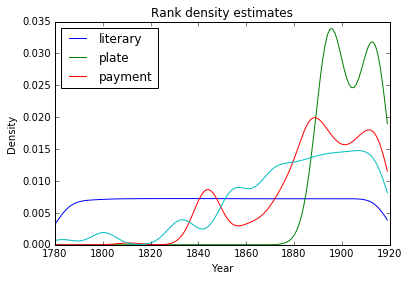

In [20]:
def plot_pdfs(tokens, years):
    for t in tokens:
        
        samples = topns.pdf(t)
        
        plt.title('Rank density estimates')
        plt.xlabel('Year')
        plt.ylabel('Density')
        plt.legend(loc='upper left')
        plt.plot(*zip(*samples.items()), label=t)
        
    plt.show()
    
plot_pdfs(
    ['literary', 'plate', 'payment', 'course'],
    range(1780, 1920),
)

And, from this, it's easy to pick out "literary" as the most constant word just by ranking the words in terms of the lowest maximum value of their PDFs - that is, words that are spread evenly across the X axis and aren't able to concentrate a significant amount of mass under any given point.

### Constant PDFs

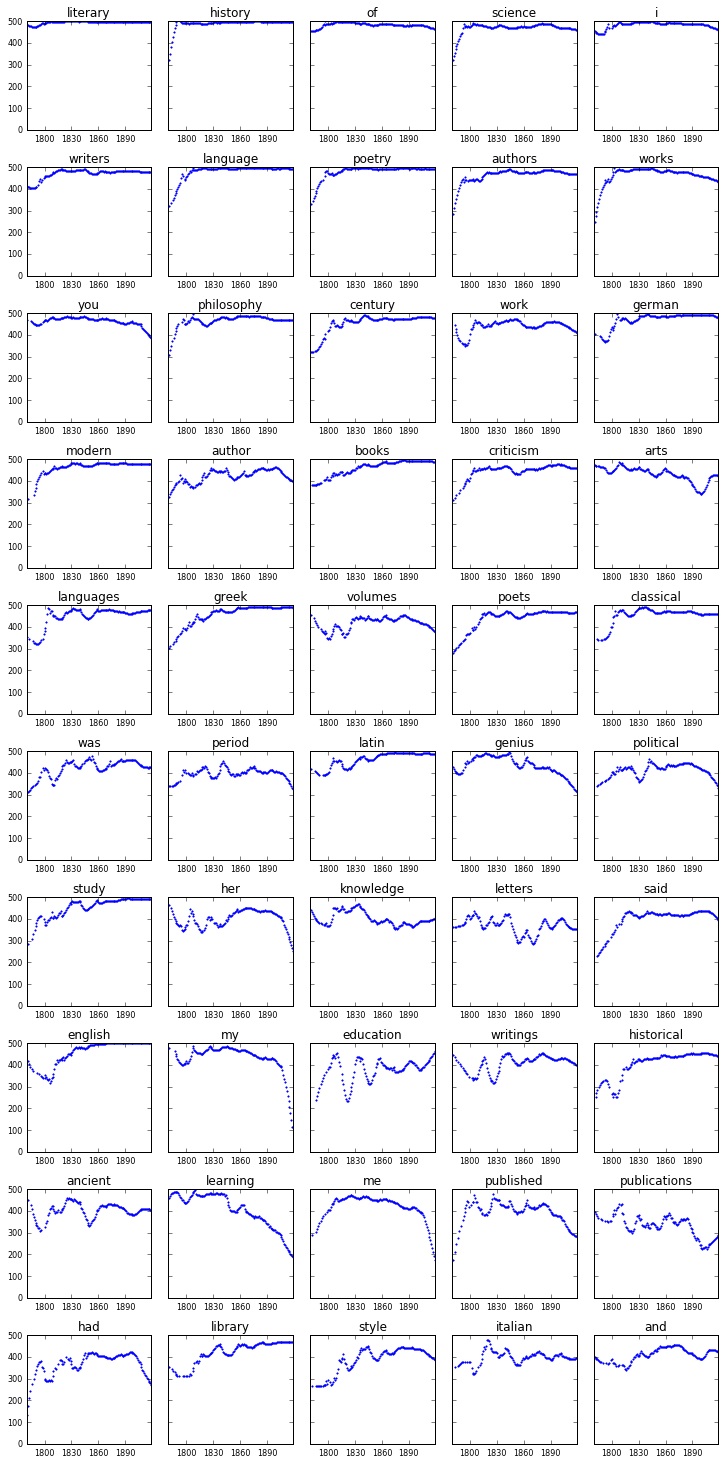

In [21]:
def print_pdf_query(_lambda, min_count=50, *args, **kwargs):
    result = topns.sort_pdfs(_lambda, min_count)
    small_multiples(result, *args, **kwargs,)
            
def score(s):
    return -max(list(s.values()))

print_pdf_query(score)

### "Peakiest" PDFs

Or, conversely, words that are the most concentrated over a particular temporal region.

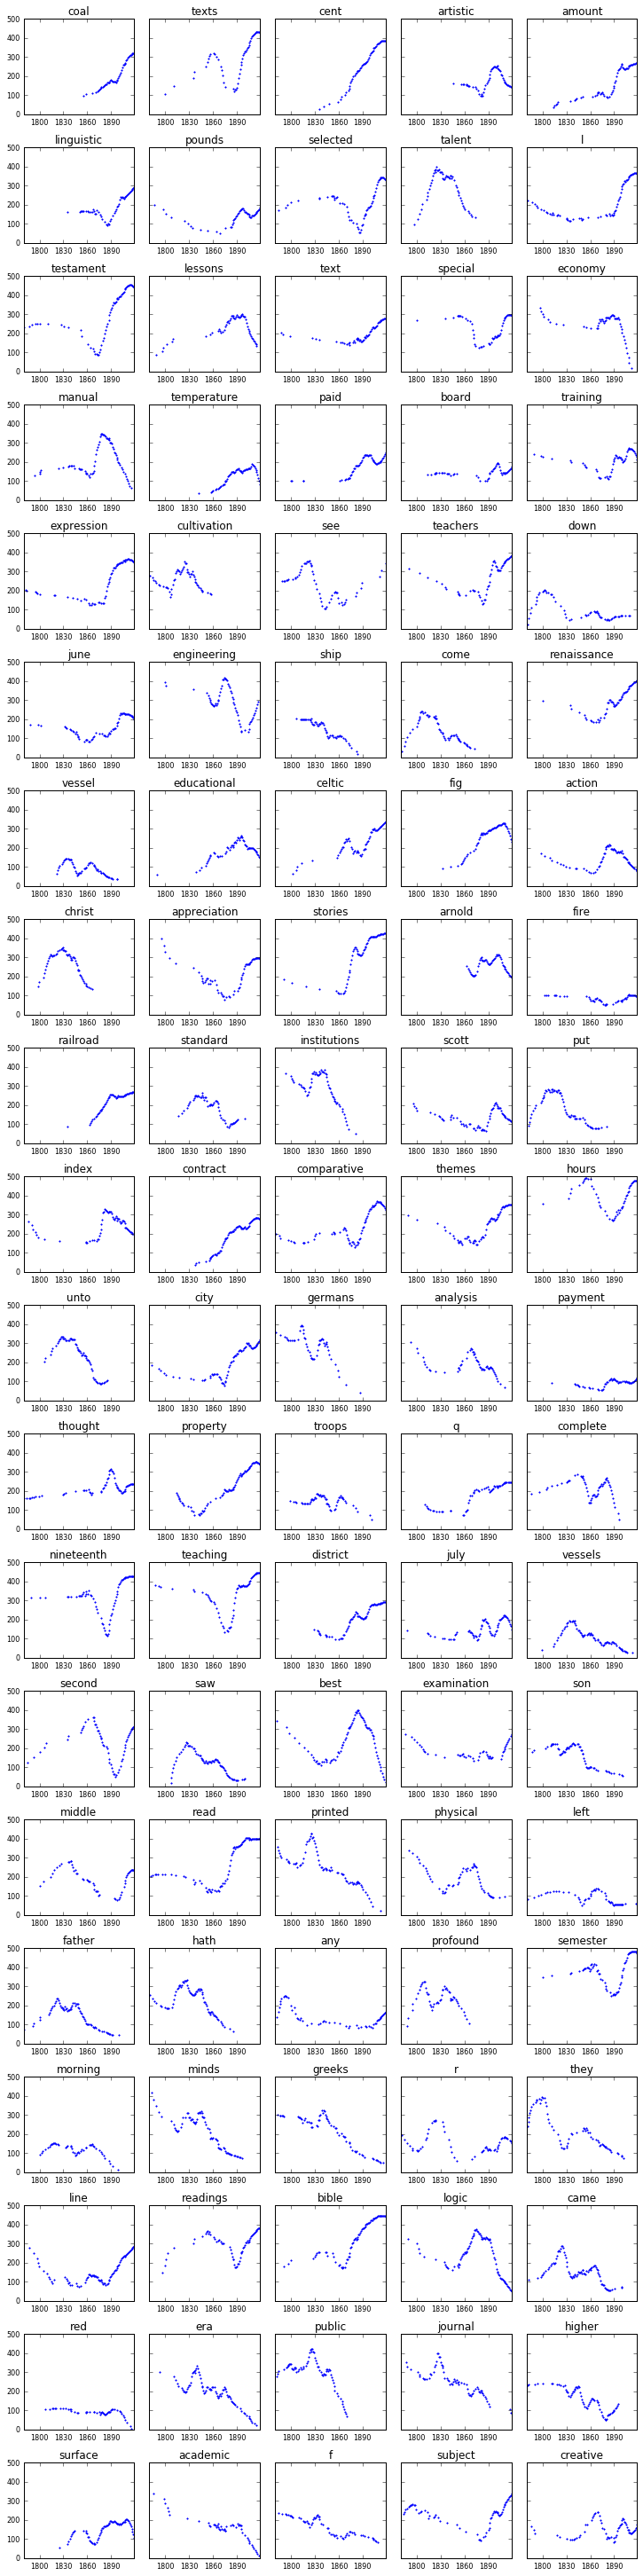

In [22]:
def score(s):
    return max(list(s.values()))

print_pdf_query(score, n=100)

### More like this

Another nice characteristic of the density functions is that we get access to a whole range of different ways of comaring the similarity between two words. Eg - given a token, what tokens have the most similar rank trends?

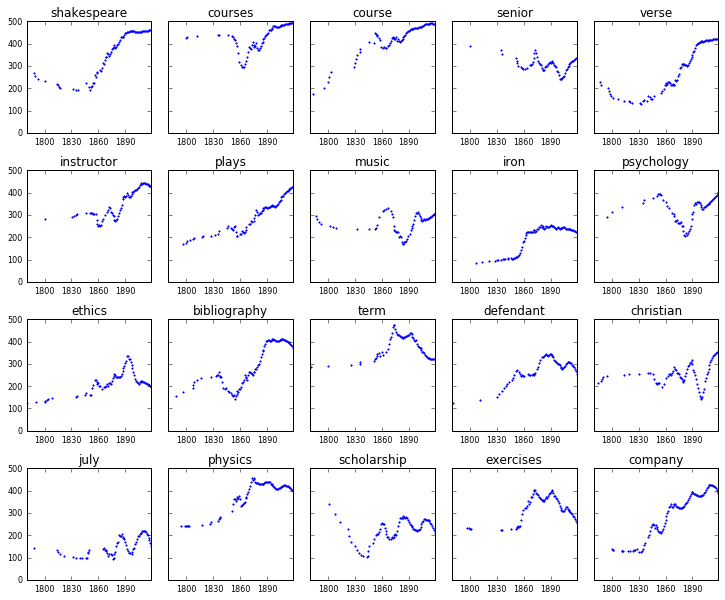

In [31]:
def print_pdfs_similar_to(token, min_count=20, *args, **kwargs):
    result = topns.pdfs_similar_to(token, min_count)
    small_multiples(result, *args, **kwargs)

print_pdfs_similar_to('shakespeare', n=20)

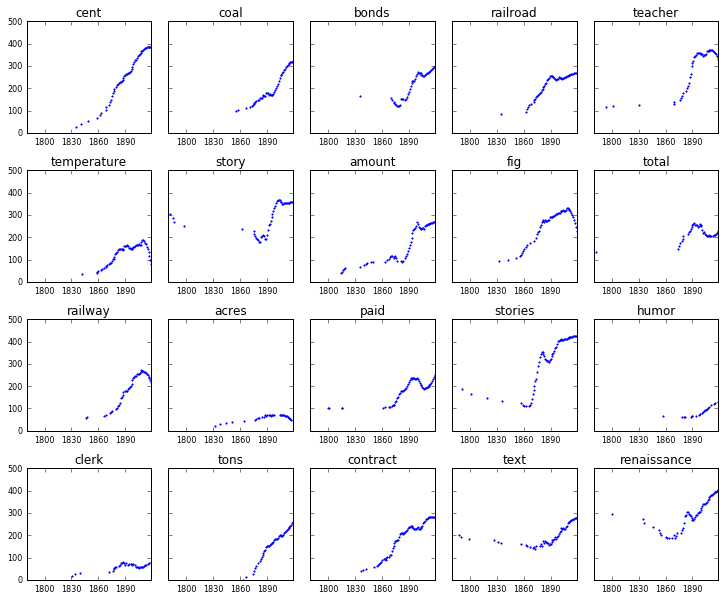

In [32]:
print_pdfs_similar_to('cent', n=20)

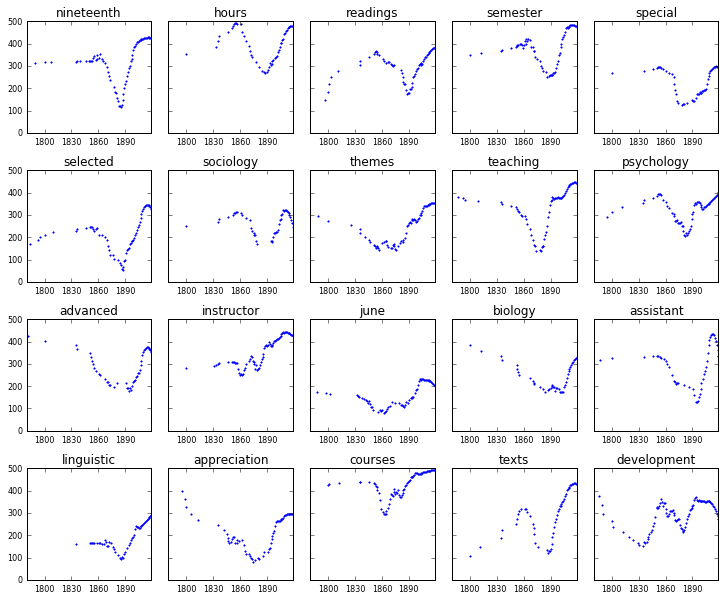

In [35]:
print_pdfs_similar_to('nineteenth', n=20)